In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import gc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import albumentations as album
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.transforms.functional import center_crop

In [5]:
DATA_DIR = './'
ENCODER = 'resnet50' # Объявляем encoder
ENCODER_WEIGHTS = 'imagenet' # Используем предобученные веса на imagenet
CLASSES = 1 # В нашей задачи мы будем искать только дороги на изображении
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 1 # Это некий ложный размер батча, после разрезки изображений он будет равен количеству пазлов из одного изображения
PATCH_SIZE = 256 # Так как наш encoder это resnet50, то нам необходим размер изображения кратный 32 - м, например, 256
NUM_EPOCHS = 50

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [7]:
class Dataset(BaseDataset):

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
            get_patches=False,
    ):
        self.image_paths = []
        self.mask_paths  = []

        # Связываем пути изображений с масками
        for image_id in os.listdir(images_dir):
            self.image_paths.append (os.path.join(images_dir, image_id)) 
            self.mask_paths.append(os.path.join(masks_dir, image_id[:-1]))

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.get_patches = get_patches


    def __getitem__(self, i):
        
        image = cv2.imread(self.image_paths[i], cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[i], cv2.COLOR_BGR2GRAY)
            
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask'] 
        
        #One hot encoding 
        new_mask = np.zeros((1, mask.shape[0], mask.shape[1]))
        new_mask[0] = np.where(mask == 0, 0, 1)

        # Используем препроцессинг, который преобразует наши входные данные под предобученные веса
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=new_mask)
            image = sample['image']
            new_mask = sample['mask']
        else:
            _transform = album.Compose([ToTensorV2()])
            transformed = _transform(image = image, mask = new_mask)
            image = transformed['image']
            new_mask  = transformed['mask']

        # Чтобы решить проблемы с большими входными изображениями, нарезаем их на батчи
        if self.get_patches:
            image = image.unfold(0, 3, 3).unfold(1,PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE,PATCH_SIZE)
            # image = image.contiguous().view(-1, 3, PATCH_SIZE, PATCH_SIZE)
            # image = image.contiguous().view(-1, 3, PATCH_SIZE, PATCH_SIZE)
            image = image.reshape(-1, 3, PATCH_SIZE, PATCH_SIZE)
            new_mask = new_mask.unfold(0, 1, 1).unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
            # new_mask = new_mask.contiguous().view(-1, 1, PATCH_SIZE, PATCH_SIZE)
            # new_mask = new_mask.contiguous().view(-1, 1, PATCH_SIZE, PATCH_SIZE)
            new_mask = new_mask.reshape(-1, 1, PATCH_SIZE, PATCH_SIZE)


        return image, new_mask
        
    def __len__(self):
        return len(self.image_paths)

## Объединение patches

In [8]:
def To_uncut_images(image = None, mask = None, predict = None):
    
    if image is not None:   
        # image = image.view(torch.Size([1, 1, 6, 6, 3, 256, 256]))
        image = image.reshape(1, 1, 6, 6, 3, 256, 256)
        # image = image.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
        image = image.permute(0, 1, 4, 2, 5, 3, 6)
        # image = image.view(1, 3, 1536, 1536)
        image = image.reshape(1, 3, 1536, 1536)

    if mask is not None:
        # mask = mask.view(torch.Size([1, 1, 6, 6, 1, 256, 256]))
        mask = mask.reshape(1, 1, 6, 6, 1, 256, 256)
        # mask = mask.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
        mask = mask.permute(0, 1, 4, 2, 5, 3, 6)
        # mask = mask.view(1, 1, 1536, 1536)
        mask = mask.reshape(1, 1, 1536, 1536)

    if predict is not None:
        # predict = predict.view(torch.Size([1, 1, 6, 6, 1, 256, 256]))
        predict = predict.reshape(1, 1, 6, 6, 1, 256, 256)
        # predict = predict.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
        predict = predict.permute(0, 1, 4, 2, 5, 3, 6)
        # predict = predict.view(1, 1, 1536, 1536)
        predict = predict.reshape(1, 1, 1536, 1536)

    return {'image' : image, 'mask' : mask, 'predict' : predict}

## Вывод изображений

In [9]:
def image_shower(images, labels, phase = None, predict = None, title = None, n=4):

    for _ in range(n):

        if phase == 'test' and predict is not None:
            fig, axes = plt.subplots(1, 3)
        else:
            fig, axes = plt.subplots(1, 2)
            
        fig.set_figwidth(12) 
        fig.set_figheight(6)

        if title is not None:
            plt.suptitle(title.upper())

        if len(images.shape) == 4:
            axes[0].imshow(images[_].numpy().transpose((1, 2, 0)).squeeze())
            axes[0].set_title('IMAGE')
            axes[1].imshow(labels[_][0].numpy().squeeze())
            axes[1].set_title('MASK')
            if predict is not None:
                axes[2].imshow(predict[_].numpy().transpose((1, 2, 0)).squeeze())
                axes[2].set_title('PREDICT_MASK')
        else:
            axes[0].imshow(images.numpy().transpose((1, 2, 0)).squeeze())
            axes[0].set_title('IMAGE')
            axes[1].imshow(labels.squeeze())
            axes[1].set_title('MASK')
    plt.show()


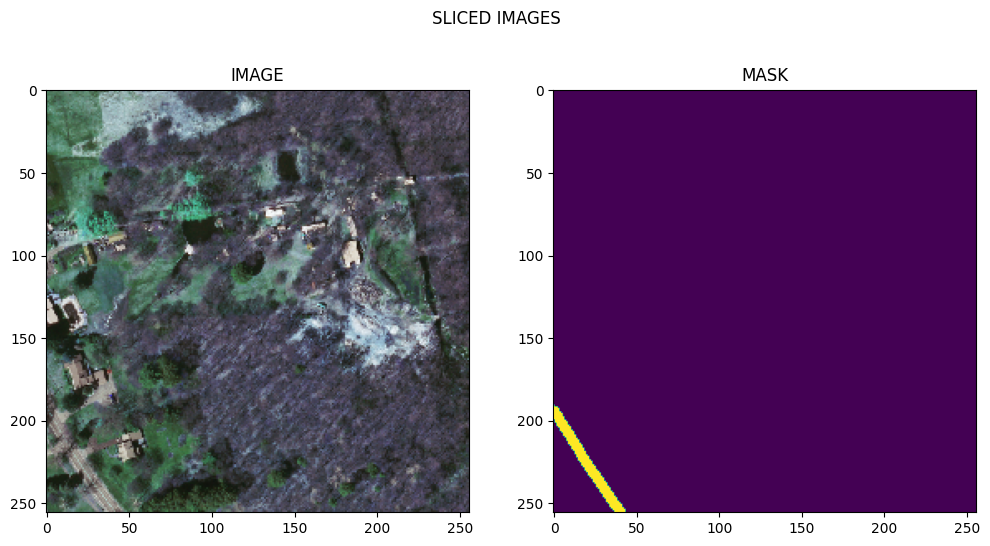

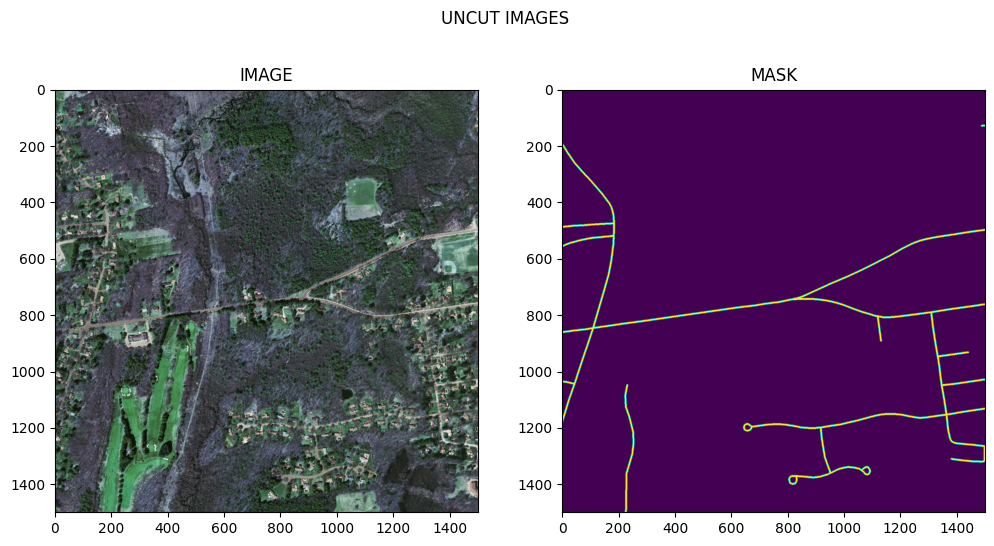

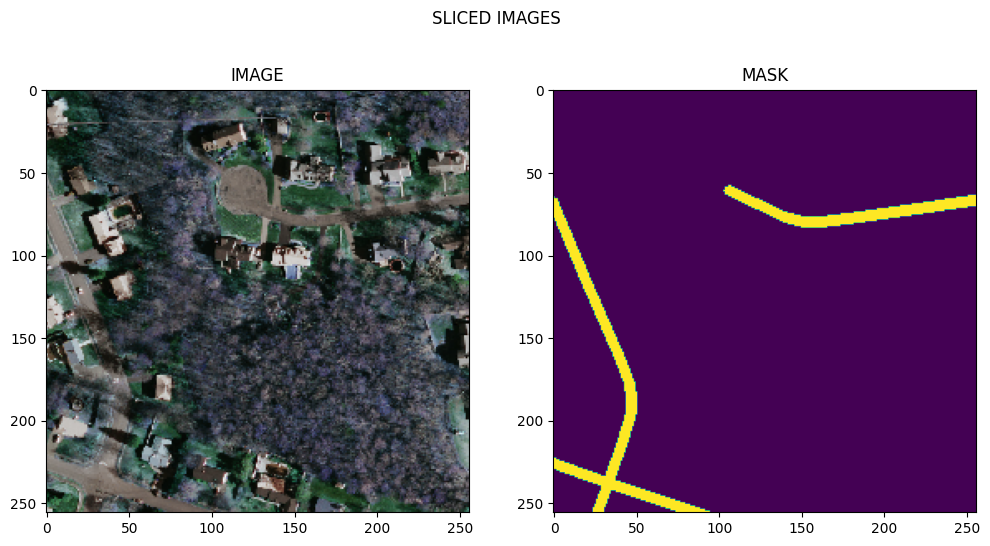

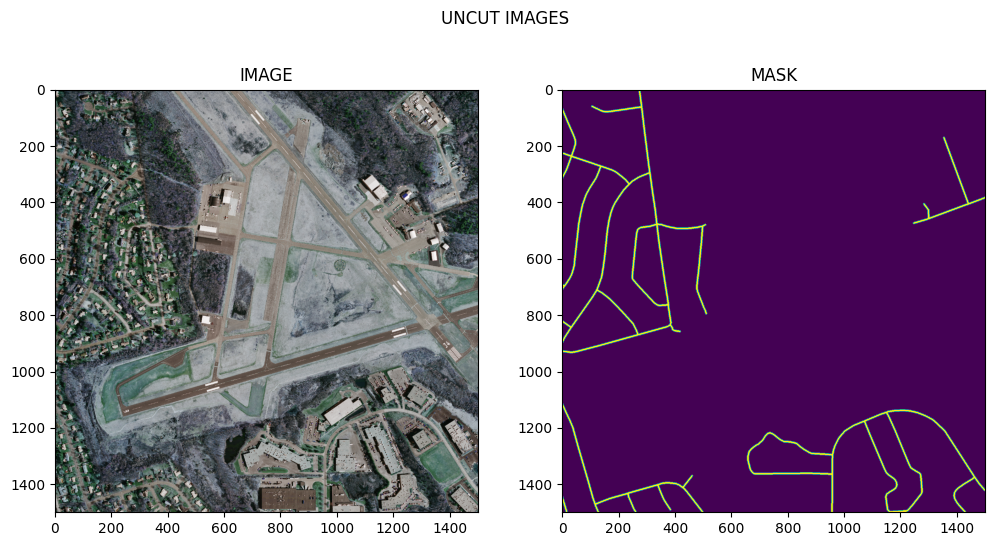

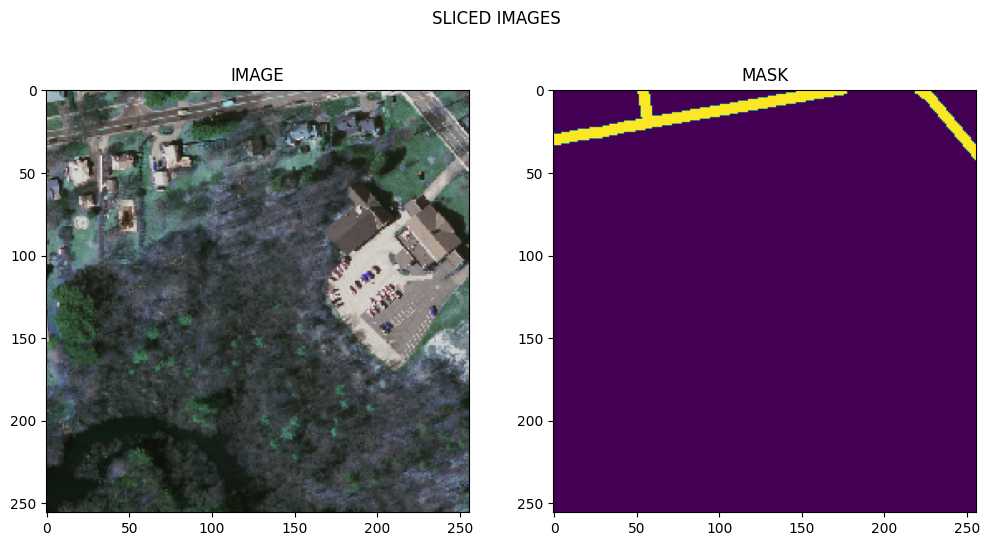

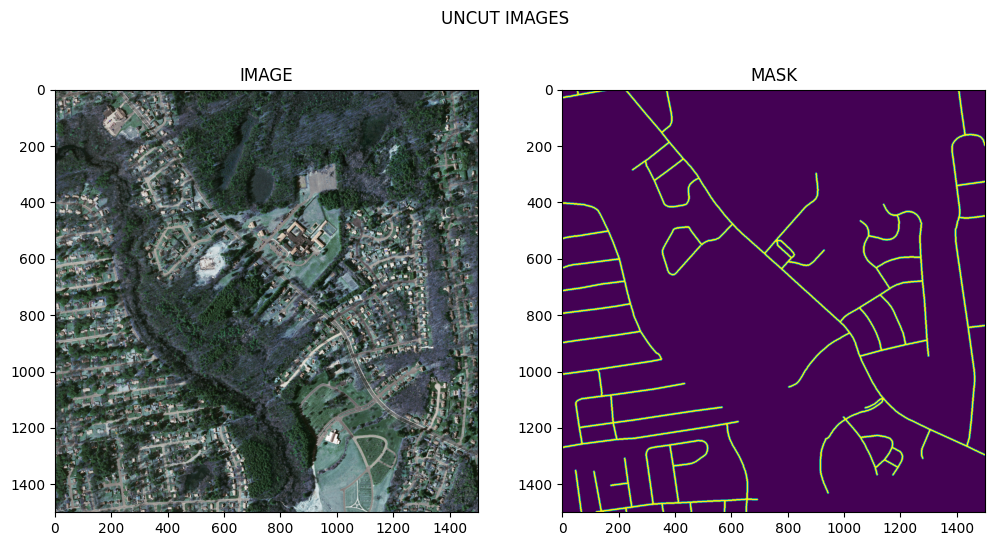

In [10]:
dataset = Dataset(x_train_dir, y_train_dir, get_patches=True)
no_cut_dataset = Dataset(x_train_dir, y_train_dir)
for i in range(3):
    random_idx = random.randint(0, len(dataset)-1)
    image, mask = dataset[random_idx] 
    images, labels = dataset[random_idx]
    image_shower(images, labels, title = "SLICED IMAGES", n=1)
    images, labels = no_cut_dataset[random_idx]
    image_shower(images, labels, title = "UNCUT IMAGES", n=1)




## Объявление аугментаций

In [11]:
def get_preprocessing(preprocessing_fn):
    _transform = [
        album.Lambda(image=preprocessing_fn),
        ToTensorV2(),
    ]
    return album.Compose(_transform)
get_augmentation = {
    'train':
        album.Compose([
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
        ]),
    'valid':
        album.Compose([
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
        ]),
    'test':
        album.Compose([
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
        ]),
}

## Инициализация итогового датасета

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


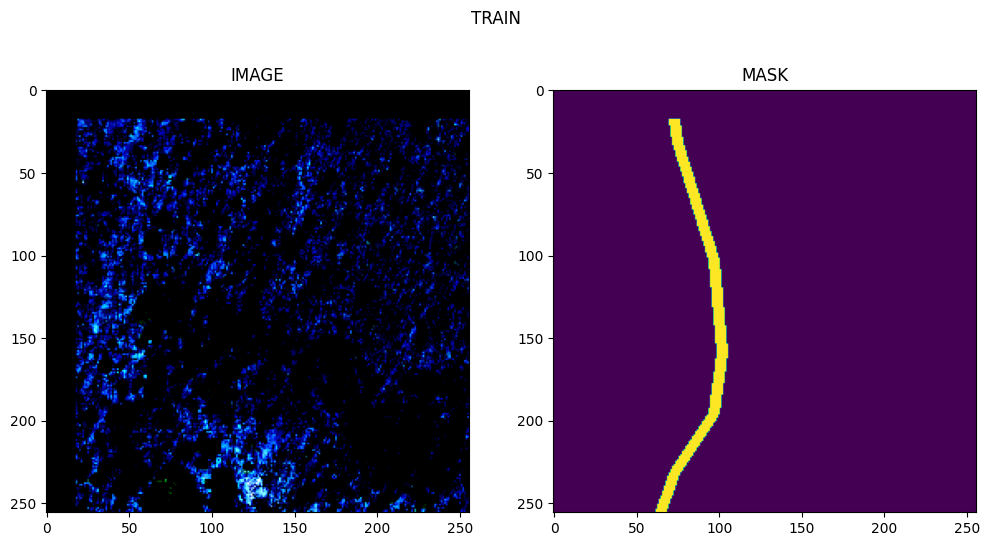

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


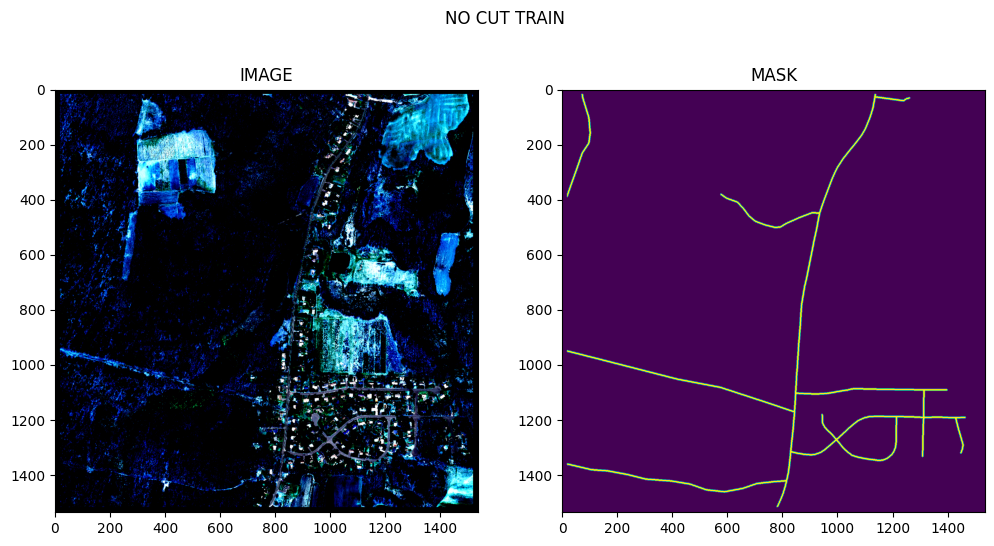

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


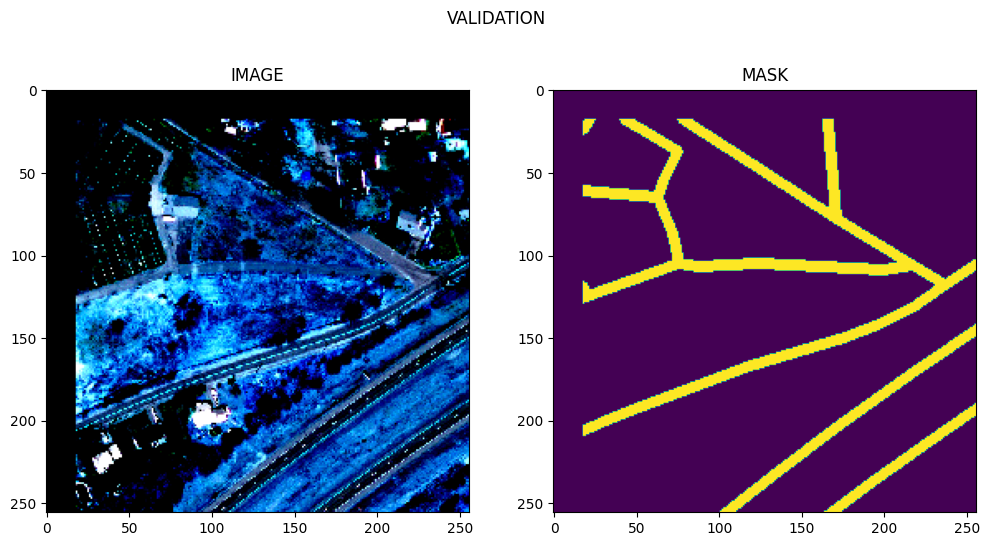

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


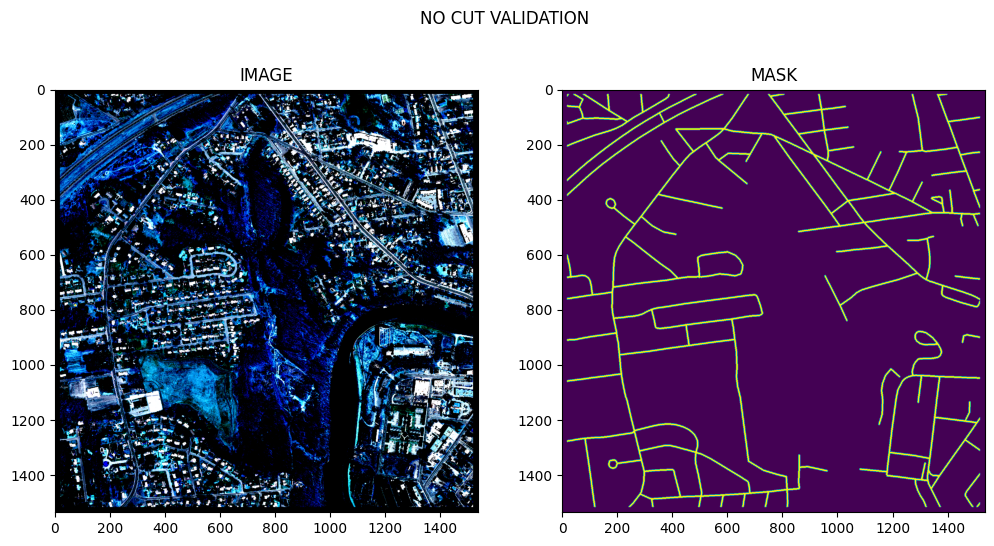

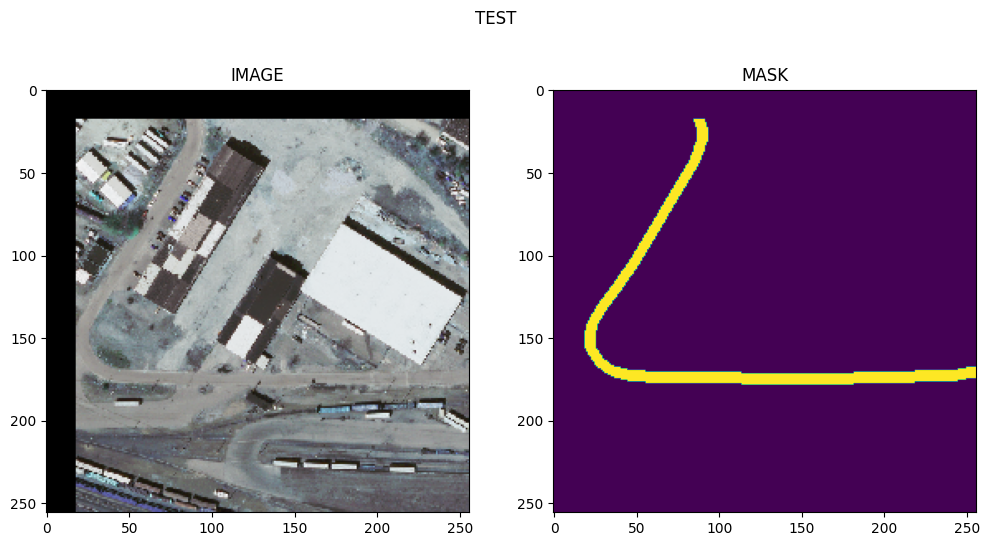

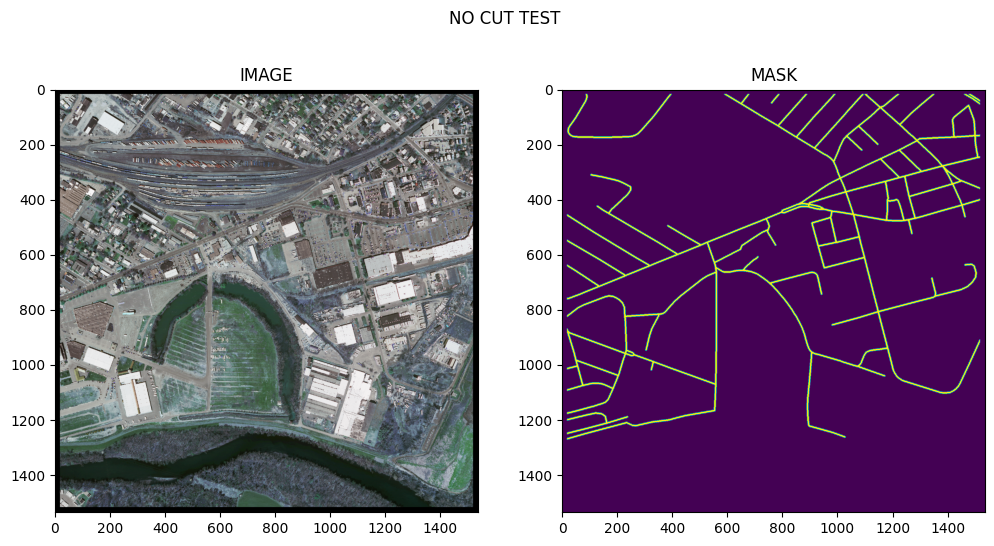

In [12]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
data_image = {
    'train':
        Dataset(x_train_dir, y_train_dir, augmentation=get_augmentation['train'], preprocessing=get_preprocessing(preprocessing_fn), get_patches=True),
    'validation':
        Dataset(x_valid_dir, y_valid_dir, augmentation=get_augmentation['valid'], preprocessing=get_preprocessing(preprocessing_fn), get_patches=True),
    'test':
        Dataset(x_test_dir, y_test_dir,augmentation=get_augmentation['test'],  get_patches=True),

}

loaders_image = {
    'train':
        DataLoader(data_image['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
    'validation':
        DataLoader(data_image['validation'], batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
    'test':
        DataLoader(data_image['test'], batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
}

for phase in data_image:
    random_idx = random.randint(0, len(data_image)-1)
    images, labels = data_image[phase][random_idx]
    image_shower(images, labels, title = phase, n=1)
    test = To_uncut_images(image = images, mask = labels)
    image_shower(test['image'], test['mask'], title = 'no cut ' + phase, n=1)


## Объявление модели

In [13]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES
)

model.to(DEVICE)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [14]:
criterion = smp.losses.SoftBCEWithLogitsLoss().to(DEVICE) #Замена для torch.nn.BCEWithLogitsLoss, но с некоторомы изменениями:
                                                                # 1 - ignore_index — указывает целевое значение, которое игнорируется и не влияет на входной градиент.
                                                                # 2 - smooth_factor — фактор для сглаживания цели (например, если smooth_factor=0,1, то [1, 0, 1] -> [0,9, 0,1, 0,9])
                                                                # => если не указывать данные параметры, то работает также, как и torch.nn.BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

## Тренировка модели

In [3]:
train_losses = []
valid_losses = []
train_iou = []
valid_iou = []
lr = [0.0001]
transform = transforms.CenterCrop((1500,1500))
def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_iou = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            out = []

            for inputs, labels in loaders_image[phase]:
                if phase == 'train':

                    inputs  = inputs.squeeze(0).float().to(DEVICE)
                    labels = labels.squeeze(0).float().to(DEVICE)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    predicts = To_uncut_images(mask = labels.long(), predict = (outputs.sigmoid()>0.5).long())
                    tp, fp, fn, tn = smp.metrics.get_stats(predicts['predict'], predicts['mask'], mode='binary')
                    out.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
                    running_loss += loss.item() * inputs.size(0)
                    
                if phase == 'validation':
                    with torch.no_grad():
                        inputs  = inputs.squeeze(0).float().to(DEVICE)
                        labels = labels.squeeze(0).float().to(DEVICE)

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        predicts = To_uncut_images(mask = labels.long(), predict = (outputs.sigmoid()>0.5).long())
                        tp, fp, fn, tn = smp.metrics.get_stats(predicts['predict'], predicts['mask'], mode='binary')
                        out.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
                        running_loss += loss.item() * inputs.size(0)
                
            lr_scheduler.step()
            lr.append(optimizer.param_groups[0]["lr"])
            epoch_loss = running_loss / len(data_image[phase])
            tp = torch.cat([x["tp"] for x in out])
            fp = torch.cat([x["fp"] for x in out])
            fn = torch.cat([x["fn"] for x in out])
            tn = torch.cat([x["tn"] for x in out])
            epoch_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item()
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_iou.append(epoch_iou)

            else:
                valid_losses.append(epoch_loss)
                valid_iou.append(epoch_iou)

                if best_iou < epoch_iou: 
                    best_iou = epoch_iou
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, './best_model.pth')
            print('{} loss: {:.4f}, epoch_iou: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_iou*100))
        print()

    return model.load_state_dict(best_model_wts)

train_model(model, criterion, optimizer)

NameError: name 'NUM_EPOCHS' is not defined

## График Loss

Text(0, 0.5, 'Loss')

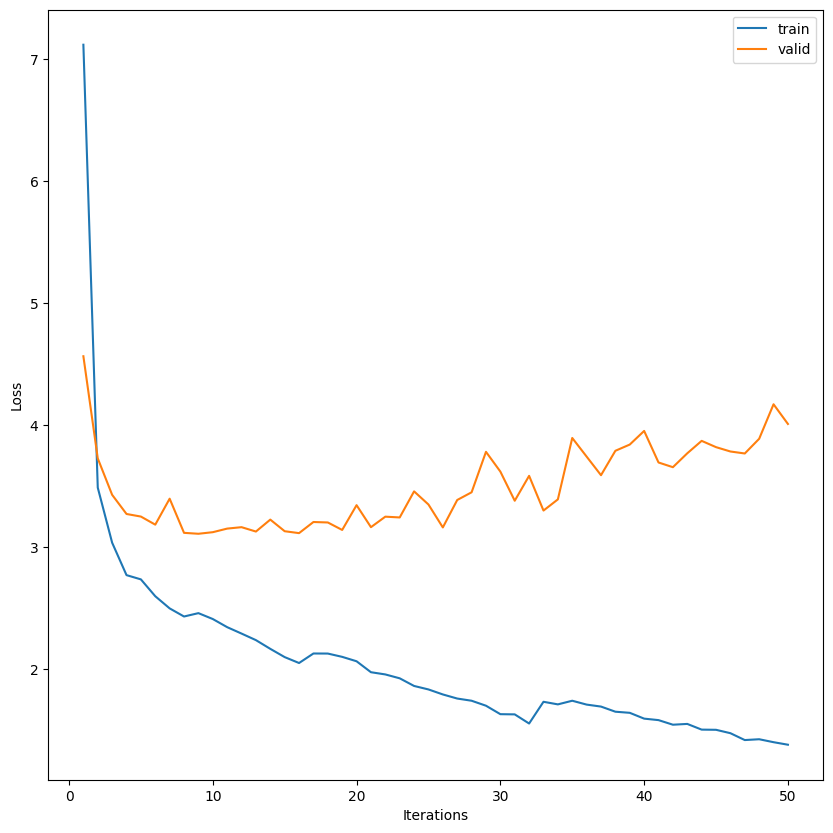

In [12]:
fig = plt.figure(figsize=(10, 10))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='train')
plt.plot(range(1, NUM_EPOCHS + 1), valid_losses, label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

## График IOU_score

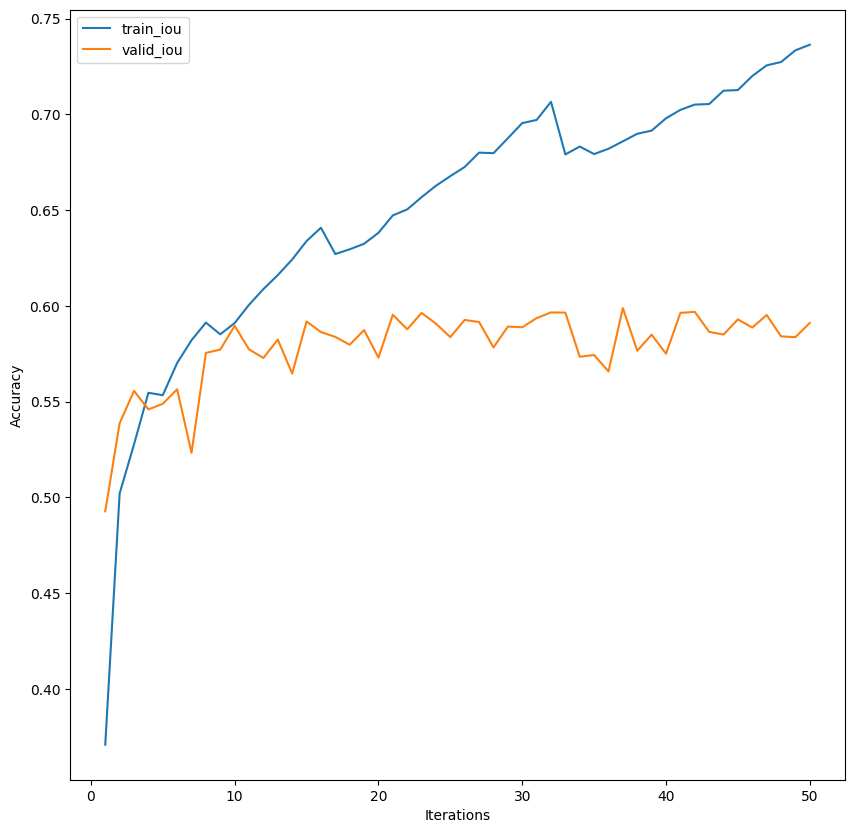

In [13]:
fig = plt.figure(figsize=(10, 10))
plt.plot(range(1, NUM_EPOCHS + 1), train_iou, label='train_iou')
plt.plot(range(1, NUM_EPOCHS + 1), valid_iou, label='valid_iou')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.show()

## График Learning rate

Text(0, 0.5, 'Lr')

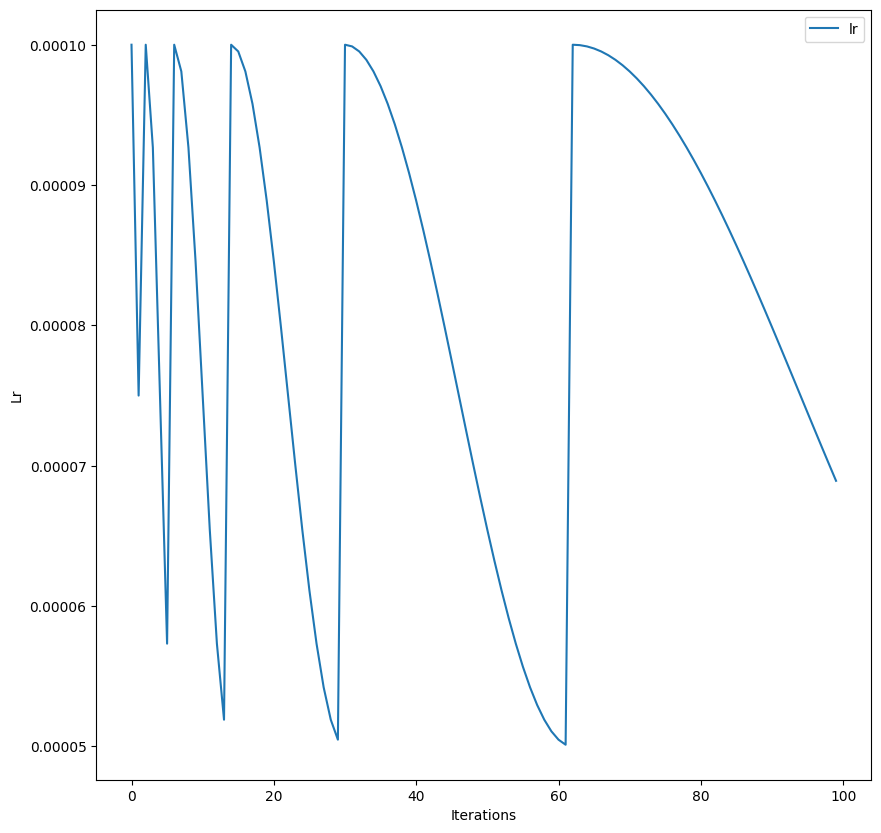

In [14]:
fig = plt.figure(figsize=(10, 10))
plt.plot(lr[1:], label='lr')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Lr')

## Тест

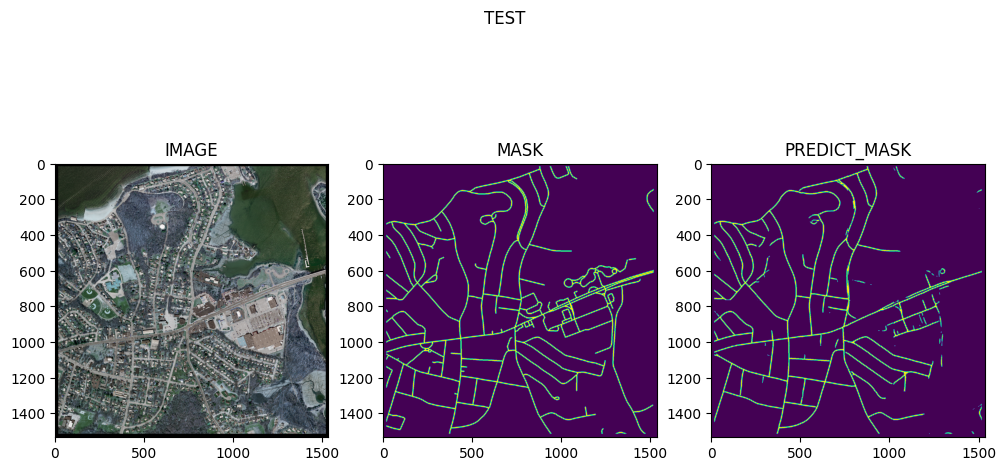

IOU of the network on the 1764 test images: 61.4866 %


In [52]:
model.load_state_dict(torch.load('./best_model.pth'))
out = []
with torch.no_grad():
    total = 0
    for i, (images, labels) in enumerate(loaders_image['test']):
        
        images = images.squeeze(0).float().to(DEVICE)
        labels = labels.squeeze(0).long().to(DEVICE)
        outputs = model(images).sigmoid()>0.5
        result = To_uncut_images(image = images.long(), mask = labels, predict = outputs.long())
        total += labels.size(0)

        if not i:
            image_shower(images=result['image'].cpu(), labels=result['mask'].cpu(), predict=result['predict'].cpu(), phase='test',title='test', n=1)

        tp, fp, fn, tn = smp.metrics.get_stats(result['predict'], result['mask'], mode='binary')
        out.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    tp = torch.cat([x["tp"] for x in out])
    fp = torch.cat([x["fp"] for x in out])
    fn = torch.cat([x["fn"] for x in out])
    tn = torch.cat([x["tn"] for x in out])
    iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item()
    print('IOU of the network on the {} test images: {:.4f} %'.format(total, 100 * iou))